## Summary
This notebook counts Fkh1/2 motif concatemers in all promoters within the budding yeast reference genome sequence

1. [Load reference genomes and PWMs](#load)
2. [PWM n-mer scores](#pwm)
3. ['AAACA' substring search](#string)
4. [Correlation to subscaling/changes](#scaling)

In [4]:
import numpy as np
from random import sample
import pandas as pd
from os import path
from re import findall
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
from tqdm import tqdm

from Bio import Seq, SeqIO
from pyfaidx import Fasta


## Load sequences and helper functions <a class="anchor" id="load"></a>

In [96]:

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Bioinformatics/Whi5/'

#23288841 is Sc assemblyID
yeast_genome = glob(path.join(dirname,f'Genomes/23288841/GCF_000146045.2_R64_genomic.fa'))
yeast_genome = Fasta(yeast_genome[0])

# All promoters from SCG
promoters = glob(path.join(dirname,f'all_S228C_ORFs/orf_genomic_1000_all.fasta'))
promoters = Fasta(promoters[0])

Fkh = pd.read_csv(path.join(dirname,'FKH2_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,9,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)


In [97]:
def nonan_pairs(x,y):
    I = ~np.isnan(x) & ~np.isnan(y)
    return x[I],y[I]

def get_pswm_score(mat,seq):
    L = len(mat)
    N = len(seq)
    return np.array([ np.sum([mat.loc[k,v] for k,v in enumerate( list(seq[i:i+L]) )]) for i in range(N-L) ])

def get_pswm_score_fast(mat: pd.DataFrame, seq: str):
    L = len(mat)
    N = len(seq)
    A = mat.columns

    # Create a lookup table: character to column index
    col_lookup = {c: i for i, c in enumerate(A)}

    # Convert sequence to numeric indices
    seq_idx = np.array([col_lookup[c] for c in seq])

    # Extract sliding windows (N-L+1, L)
    windows = np.lib.stride_tricks.sliding_window_view(seq_idx, window_shape=L)

    # Now we need to look up mat.loc[k, v] for each position k and base v
    # windows.shape = (N-L+1, L)
    # So we construct two arrays:
    #   rows = [0, 1, 2, ..., L-1]
    #   cols = windows[i, :]
    row_idx = np.arange(L)  # Shape (L,)
    scores = np.array([mat.values[row_idx, win] for win in windows])

    return scores.sum(axis=1)

def extract_promoters_by_gene_name(promoters,genes):
    return [SeqRecord( Seq(promoters[name][500:1000].seq), id=name) 
                          for name in genes if name in promoters.keys()]

def calculate_motif_score_on_seqdict(seqdict,motif):
    
    prom_scores = {gene: get_pswm_score_fast(motif,seq[500:1000].seq) for gene,seq in tqdm(seqdict.items()) if not gene.startswith('Q')}
    
    mean_scores = {gene: score.mean() for gene,score in prom_scores.items()}
    max_scores = {gene: score.max() for gene,score in prom_scores.items()}
    argmax_scores = {gene: score.argmax() for gene,score in prom_scores.items()}
    sum_scores = {gene: score.sum() for gene,score in prom_scores.items()}
    
    df = pd.DataFrame([mean_scores,max_scores,sum_scores,argmax_scores]).T
    df.columns = ['Mean','Max','Sum','Argmax']
    df.sort_values('Mean',ascending=False).head(10)
    return df

def plot_score_and_highlight_whi5(scores,field='Max',motif_name='Fkh'):
    plt.hist(scores[field],100)
    plt.vlines(scores.loc['YOR083W',field],ymin=0,ymax=200,color='r')
    plt.xlabel(f'{motif_name} motif score')
    plt.legend(['Whi5 promoters','All SC promoter'])

## Calculate sequence motif scores for Fkh n-mers

Full Fkh motif: 0         A         T         G         C
0  0.206502  0.000792  0.791914  0.000792
1  0.128588  0.748363  0.122300  0.000748
2  0.820153  0.000820  0.000820  0.178207
3  0.997009  0.000997  0.000997  0.000997
4  0.997009  0.000997  0.000997  0.000997
5  0.009486  0.118662  0.009291  0.862560
6  0.997009  0.000997  0.000997  0.000997


100%|█████████████████████████████████████| 6722/6722 [00:03<00:00, 1684.49it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


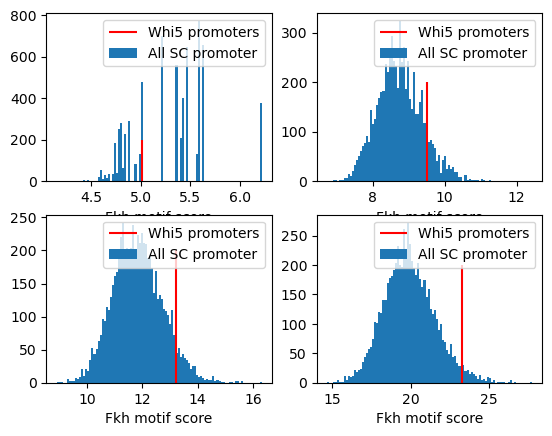

In [99]:
'''
Full Fkh motif scores
'''
print(f'Full Fkh motif: {Fkh}')

#%% Calculate full Fkh score on all promoter sequence and all chromosomal sequenc
df_full_1mer = calculate_motif_score_on_seqdict(promoters,Fkh)
df_full_2mer = calculate_motif_score_on_seqdict(promoters,pd.concat((Fkh,Fkh),ignore_index=True))
df_full_3mer = calculate_motif_score_on_seqdict(promoters,pd.concat((Fkh,Fkh,Fkh),ignore_index=True))
df_full_6mer = calculate_motif_score_on_seqdict(promoters,pd.concat((Fkh,Fkh,Fkh,Fkh,Fkh,Fkh),ignore_index=True))

plt.subplot(2,2,1)
plot_score_and_highlight_whi5(df_full_1mer)
plt.subplot(2,2,2)
plot_score_and_highlight_whi5(df_full_2mer)
plt.subplot(2,2,3)
plot_score_and_highlight_whi5(df_full_3mer)
plt.subplot(2,2,4)
plot_score_and_highlight_whi5(df_full_6mer)
plt.savefig(path.join(dirname,'full_fkh_nmer_scores.eps'),format='eps')


In [100]:
# 'Calibrate' 2mer v. 3mer etc scores for full scores
from numpy import random
def generate_random_sequence(frequencies,n):
    # convert frequency table to cumulatives and do metropolis
    cumu_freq = dict(zip(frequencies.keys(),np.cumsum(list(frequencies.values()))))
    p = random.rand(n)
    nt = list(frequencies.keys())
    seq = pd.Series(range(n))
    seq.loc[p < cumu_freq[nt[0]]] = nt[0]
    seq.loc[(p > cumu_freq[nt[0]]) & (p <= cumu_freq[nt[1]])] = nt[1]
    seq.loc[(p > cumu_freq[nt[1]]) & (p <= cumu_freq[nt[2]])] = nt[2]
    seq.loc[(p > cumu_freq[nt[2]])] = nt[3]
    return ''.join(seq.values)

from collections import Counter
from operator import add
from functools import reduce
counts = [Counter(seq[500:1000].seq) for seq in promoters.values()]
frequencies = pd.Series(reduce(add, counts))
frequencies = (frequencies / frequencies.sum()).to_dict()

Niters = 1000
synthetic_scores = pd.DataFrame(index=range(Niters),columns=['two-mer','three-mer','four-mer','five-mer','six-mer'])
for i in range(Niters):
    s = generate_random_sequence(frequencies,len(pd.concat((Fkh,Fkh,Fkh,Fkh,Fkh,Fkh))))
    two_mer = 'GTAAACAGTAAACA' + s[14:]
    three_mer = 'GTAAACAGTAAACAGTAAACA' + s[21:]
    four_mer = 'GTAAACAGTAAACAGTAAACAGTAAACA' + s[28:]
    five_mer = 'GTAAACAGTAAACAGTAAACAGTAAACAGTAAACA' + s[35:]
    six_mer = 'GTAAACAGTAAACAGTAAACAGTAAACAGTAAACAGTAAACA'
    
    # synthetic_scores.loc[i,'one-mer'] = \
    #     get_pswm_score_fast(pd.concat((truncFkh,truncFkh,truncFkh,truncFkh,truncFkh,truncFkh),ignore_index=True),one_mer).max()
    synthetic_scores.loc[i,'two-mer'] = \
        get_pswm_score_fast(pd.concat((Fkh,Fkh,Fkh,Fkh,Fkh,Fkh),ignore_index=True),two_mer).max()
    synthetic_scores.loc[i,'three-mer'] = \
        get_pswm_score_fast(pd.concat((Fkh,Fkh,Fkh,Fkh,Fkh,Fkh),ignore_index=True),three_mer).max()
    synthetic_scores.loc[i,'four-mer'] = \
        get_pswm_score_fast(pd.concat((Fkh,Fkh,Fkh,Fkh,Fkh,Fkh),ignore_index=True),four_mer).max()
    synthetic_scores.loc[i,'five-mer'] = \
        get_pswm_score_fast(pd.concat((Fkh,Fkh,Fkh,Fkh,Fkh,Fkh),ignore_index=True),five_mer).max()
    synthetic_scores.loc[i,'six-mer'] = \
        get_pswm_score_fast(pd.concat((Fkh,Fkh,Fkh,Fkh,Fkh,Fkh),ignore_index=True),six_mer).max()


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_53524/28591935.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seq.loc[p < cumu_freq[nt[0]]] = nt[0]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


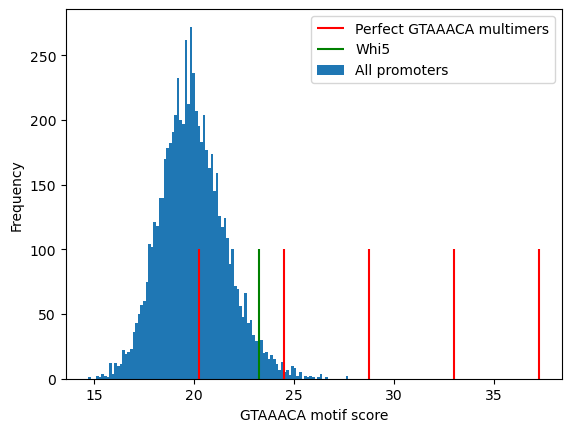

In [109]:
plt.hist(df_full_6mer['Max'],100)
plt.vlines(synthetic_scores.mean(),ymin=0,ymax=100,color='red')
plt.vlines(df_full_6mer.loc['YOR083W','Max'],ymin=0,ymax=100,color='green')
plt.legend(['Perfect GTAAACA multimers','Whi5','All promoters',])
plt.xlabel('GTAAACA motif score')
plt.ylabel('Frequency')

plt.savefig(path.join(dirname,'full_fkh_nmer_scores_calibrated.eps'),format='eps')

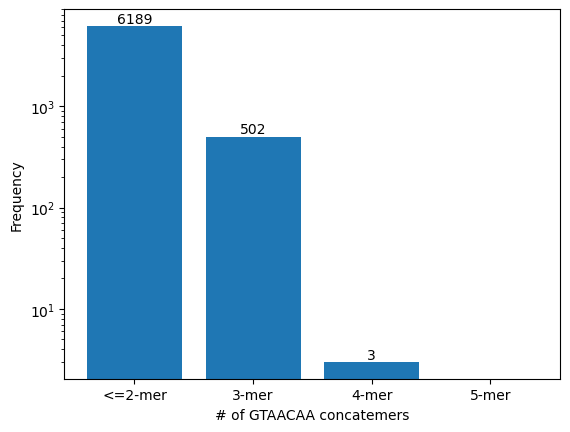

In [115]:
bin_edges = synthetic_scores.mean().values[:-1] + np.diff(synthetic_scores.mean())/2
bin_edges = np.insert(bin_edges,0,0)
# bin_edges = np.append(bin_edges,30)

counts,bins = np.histogram(df_full_6mer['Max'],bins= bin_edges)
df_full_6mer['# concats'] = np.digitize(df_full_6mer['Max'].astype(float),bins= bin_edges.astype(float))+1
plt.yscale('log', nonpositive='clip')
container = plt.bar(range(len(counts)),counts)
plt.bar_label(container,counts)
plt.xlabel('# of GTAACAA concatemers')
plt.ylabel('Frequency')
g = plt.gca()
g.set_xticks(range(len(counts)),labels=['<=2-mer','3-mer','4-mer','5-mer'])

plt.savefig(path.join(dirname,'full_fkh_nmer_scores_binned.eps'),format='eps')

Truncated Fkh (AAACA): 0         A         T         G         C
0  0.820153  0.000820  0.000820  0.178207
1  0.997009  0.000997  0.000997  0.000997
2  0.997009  0.000997  0.000997  0.000997
3  0.009486  0.118662  0.009291  0.862560
4  0.997009  0.000997  0.000997  0.000997


100%|█████████████████████████████████████| 6722/6722 [00:03<00:00, 1689.56it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


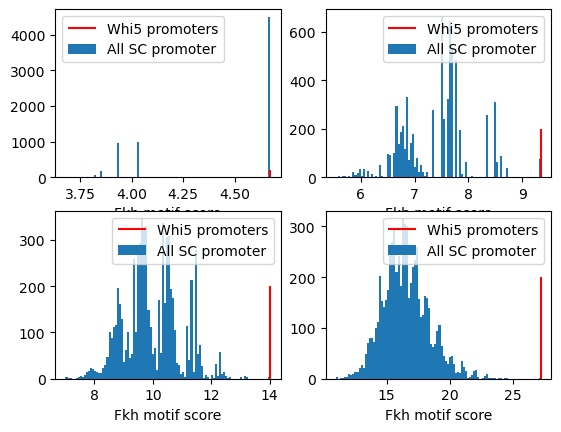

In [11]:
'''
Truncated Fkh motif scores (AAACA) only
'''

truncFkh = Fkh.loc[[1,2,3,4,5]].reset_index(drop=True)
print(f'Truncated Fkh (AAACA): {truncFkh}')

#%% Calculate full Fkh score on all promoter sequence and all chromosomal sequenc
df_trunc_1mer = calculate_motif_score_on_seqdict(promoters,truncFkh)
df_trunc_2mer = calculate_motif_score_on_seqdict(promoters,pd.concat((truncFkh,truncFkh),ignore_index=True))
df_trunc_3mer = calculate_motif_score_on_seqdict(promoters,pd.concat((truncFkh,truncFkh,truncFkh),ignore_index=True))
df_trunc_6mer = calculate_motif_score_on_seqdict(promoters,pd.concat((truncFkh,truncFkh,truncFkh,
                                                                     truncFkh,truncFkh,truncFkh),ignore_index=True))

plt.subplot(2,2,1)
plot_score_and_highlight_whi5(df_trunc_1mer)
plt.subplot(2,2,2)
plot_score_and_highlight_whi5(df_trunc_2mer)
plt.subplot(2,2,3)
plot_score_and_highlight_whi5(df_trunc_3mer)
plt.subplot(2,2,4)
plot_score_and_highlight_whi5(df_trunc_6mer)
plt.savefig(path.join(dirname,'truncated_fkh_nmer_scores.eps'),format='eps')


In [12]:
# 'Calibrate' 2mer v. 3mer etc scores
from numpy import random
def generate_random_sequence(frequencies,n):
    # convert frequency table to cumulatives
    cumu_freq = dict(zip(frequencies.keys(),np.cumsum(list(frequencies.values()))))
    p = random.rand(n)
    nt = list(frequencies.keys())
    seq = pd.Series(range(n))
    seq.loc[p < cumu_freq[nt[0]]] = nt[0]
    seq.loc[(p > cumu_freq[nt[0]]) & (p <= cumu_freq[nt[1]])] = nt[1]
    seq.loc[(p > cumu_freq[nt[1]]) & (p <= cumu_freq[nt[2]])] = nt[2]
    seq.loc[(p > cumu_freq[nt[2]])] = nt[3]
    return ''.join(seq.values)

from collections import Counter
from operator import add
from functools import reduce
counts = [Counter(seq[500:1000].seq) for seq in promoters.values()]
frequencies = pd.Series(reduce(add, counts))
frequencies = (frequencies / frequencies.sum()).to_dict()

Niters = 1000
synthetic_scores = pd.DataFrame(index=range(Niters),columns=['two-mer','three-mer','four-mer','five-mer','six-mer'])
for i in range(Niters):
    s = generate_random_sequence(frequencies,len(pd.concat((truncFkh,truncFkh,truncFkh,truncFkh,truncFkh,truncFkh))))
    two_mer = 'AAACAAAACA' + s[10:]
    three_mer = 'AAACAAAACAAAACA' + s[15:]
    four_mer = 'AAACAAAACAAAACAAAACA' + s[20:]
    five_mer = 'AAACAAAACAAAACAAAACAAAACA' + s[25:]
    six_mer = 'AAACAAAACAAAACAAAACAAAACAAAACA'
    
    # synthetic_scores.loc[i,'one-mer'] = \
    #     get_pswm_score_fast(pd.concat((truncFkh,truncFkh,truncFkh,truncFkh,truncFkh,truncFkh),ignore_index=True),one_mer).max()
    synthetic_scores.loc[i,'two-mer'] = \
        get_pswm_score_fast(pd.concat((truncFkh,truncFkh,truncFkh,truncFkh,truncFkh,truncFkh),ignore_index=True),two_mer).max()
    synthetic_scores.loc[i,'three-mer'] = \
        get_pswm_score_fast(pd.concat((truncFkh,truncFkh,truncFkh,truncFkh,truncFkh,truncFkh),ignore_index=True),three_mer).max()
    synthetic_scores.loc[i,'four-mer'] = \
        get_pswm_score_fast(pd.concat((truncFkh,truncFkh,truncFkh,truncFkh,truncFkh,truncFkh),ignore_index=True),four_mer).max()
    synthetic_scores.loc[i,'five-mer'] = \
        get_pswm_score_fast(pd.concat((truncFkh,truncFkh,truncFkh,truncFkh,truncFkh,truncFkh),ignore_index=True),five_mer).max()
    synthetic_scores.loc[i,'six-mer'] = \
        get_pswm_score_fast(pd.concat((truncFkh,truncFkh,truncFkh,truncFkh,truncFkh,truncFkh),ignore_index=True),six_mer).max()


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_53524/2436814053.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seq.loc[p < cumu_freq[nt[0]]] = nt[0]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


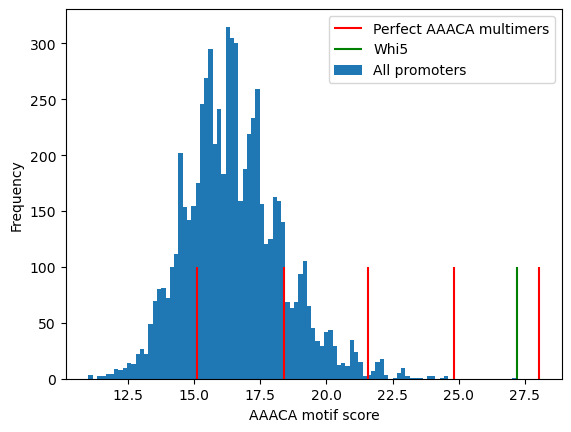

In [10]:
plt.hist(df_trunc_6mer['Max'],100)
plt.vlines(synthetic_scores.mean(),ymin=0,ymax=100,color='red')
plt.vlines(df_trunc_6mer.loc['YOR083W','Max'],ymin=0,ymax=100,color='green')
plt.legend(['Perfect AAACA multimers','Whi5','All promoters',])
plt.xlabel('AAACA motif score')
plt.ylabel('Frequency')

plt.savefig(path.join(dirname,'truncated_fkh_nmer_scores_calibrated.eps'),format='eps')

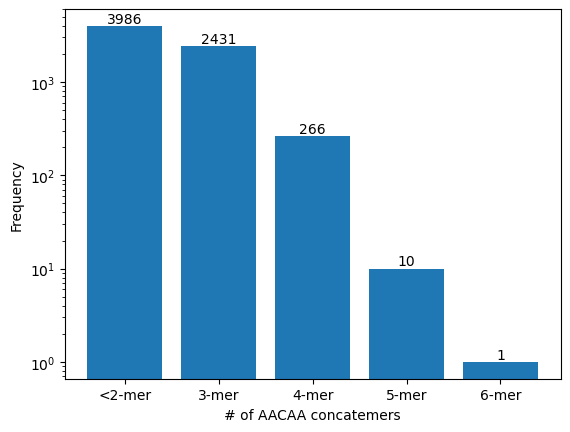

In [22]:
bin_edges = synthetic_scores.mean().values[:-1] + np.diff(synthetic_scores.mean())/2
bin_edges = np.insert(bin_edges,0,0)
bin_edges = np.append(bin_edges,30)

counts,bins = np.histogram(df_trunc_6mer['Max'],bins= bin_edges)
df_trunc_6mer['# concats'] = np.digitize(df_trunc_6mer['Max'].astype(float),bins= bin_edges.astype(float))+1
plt.yscale('log', nonpositive='clip')
container = plt.bar(range(len(counts)),counts)
plt.bar_label(container,counts)
plt.xlabel('# of AACAA concatemers')
plt.ylabel('Frequency')
g = plt.gca()
g.set_xticks(range(len(counts)),labels=['<2-mer','3-mer','4-mer','5-mer','6-mer'])

plt.savefig(path.join(dirname,'truncated_fkh_nmer_scores_binned.eps'),format='eps')

In [118]:
from pyfaidx import Fasta

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Bioinformatics/Whi5/'

# All promoters from SCG
promoters = glob(path.join(dirname,f'all_S228C_ORFs/orf_genomic_1000_all.fasta'))
promoters = Fasta(promoters[0])

hit_sequence = pd.DataFrame()
for gene,seq in promoters.items():
    if gene.startswith('Q'): # questionable
        continue
    pos = int(df_trunc_6mer.loc[gene,'Argmax'])
    hit_sequence.loc[gene,'Sequence'] = promoters[gene][500+pos:500+pos+50].seq

delta_slopes = pd.read_csv(path.join(dirname,'delta_slopes.csv'),index_col=0)

df_6mer = df_trunc_6mer.join(hit_sequence).join(delta_slopes)
df_6mer.sort_values('Max',ascending=False).to_csv(path.join(dirname,'truncated_6mer_joined.csv'))
df_6mer.sort_values('Max',ascending=False).dropna().head(20)

df_6mer = df_full_6mer.join(hit_sequence).join(delta_slopes)
df_6mer.sort_values('Max',ascending=False).to_csv(path.join(dirname,'full_6mer_joined.csv'))
df_6mer.sort_values('Max',ascending=False).dropna().head(20)
df_6mer['# concats']

YAL069W      2
YAL068W-A    2
YAL068C      2
YAL067W-A    2
YAL067C      2
            ..
YPR201W      2
YPR202W      2
YPR203W      2
YPR204W      2
YPR204C-A    2
Name: # concats, Length: 6694, dtype: int64

In [26]:
print('--- Full Fkh motif ---')
whi5_1mer_rank = np.where(df_full_1mer.sort_values('Max').index == 'YOR083W')[0][0]
whi5_2mer_rank = np.where(df_full_2mer.sort_values('Max').index == 'YOR083W')[0][0]
whi5_3mer_rank = np.where(df_full_3mer.sort_values('Max').index == 'YOR083W')[0][0]
whi5_6mer_rank = np.where(df_full_6mer.sort_values('Max').index == 'YOR083W')[0][0]

print(f'Whi5 promoter 1mer rank: {len(df_full_1mer)-whi5_1mer_rank} out of {len(df_full_1mer)}')
print(f'Whi5 promoter 2mer rank: {len(df_full_1mer)-whi5_2mer_rank} out of {len(df_full_1mer)}')
print(f'Whi5 promoter 3mer rank: {len(df_full_1mer)-whi5_3mer_rank} out of {len(df_full_1mer)}')
print(f'Whi5 promoter 3mer rank: {len(df_full_1mer)-whi5_6mer_rank} out of {len(df_full_1mer)}')

print('--- Truncated Fkh motif ---')
whi5_1mer_rank = np.where(df_trunc_1mer.sort_values('Max').index == 'YOR083W')[0][0]
whi5_2mer_rank = np.where(df_trunc_2mer.sort_values('Max').index == 'YOR083W')[0][0]
whi5_3mer_rank = np.where(df_trunc_3mer.sort_values('Max').index == 'YOR083W')[0][0]
whi5_6mer_rank = np.where(df_trunc_6mer.sort_values('Max').index == 'YOR083W')[0][0]

print(f'Whi5 promoter 1mer rank: {len(df_full_1mer)-whi5_1mer_rank} out of {len(df_trunc_2mer)}')
print(f'Whi5 promoter 2mer rank: {len(df_full_1mer)-whi5_2mer_rank} out of {len(df_trunc_2mer)}')
print(f'Whi5 promoter 3mer rank: {len(df_full_1mer)-whi5_3mer_rank} out of {len(df_trunc_2mer)}')
print(f'Whi5 promoter 3mer rank: {len(df_full_1mer)-whi5_6mer_rank} out of {len(df_trunc_2mer)}')

--- Full Fkh motif ---
Whi5 promoter 1mer rank: 2405 out of 6694
Whi5 promoter 2mer rank: 647 out of 6694
Whi5 promoter 3mer rank: 119 out of 6694
Whi5 promoter 3mer rank: 55 out of 6694
--- Truncated Fkh motif ---
Whi5 promoter 1mer rank: 2769 out of 6694
Whi5 promoter 2mer rank: 1 out of 6694
Whi5 promoter 3mer rank: 3 out of 6694
Whi5 promoter 3mer rank: 1 out of 6694


## Find other promoters that have n-mers <a class="anchor" id="pwm"></a>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


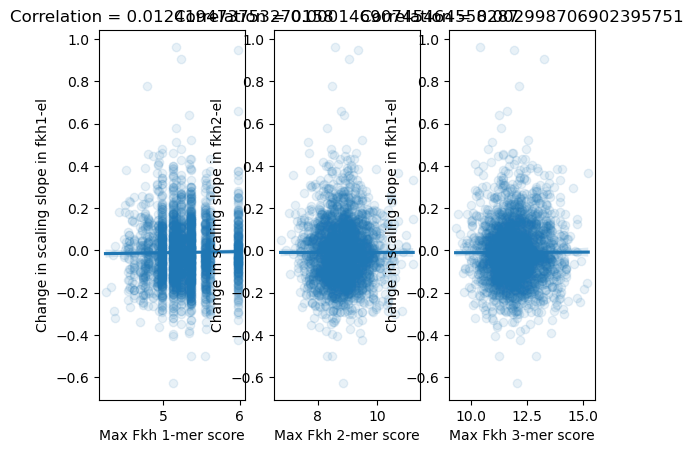

In [27]:
plt.subplot(1,3,1)
sb.regplot(df_full_1mer.join(delta_slopes), x='Max',y='fkh1_deviation_from_wt',scatter_kws={'alpha':0.1})
plt.xlabel('Max Fkh 1-mer score')
plt.ylabel('Change in scaling slope in fkh1-el')
R,P = np.corrcoef(*nonan_pairs(df_full_1mer.join(delta_slopes)['Max'],
                  df_full_1mer.join(delta_slopes)['fkh1_deviation_from_wt']))
plt.title(f'Correlation = {R[1]}')

plt.subplot(1,3,2)
sb.regplot(df_full_2mer.join(delta_slopes), x='Max',y='fkh1_deviation_from_wt',scatter_kws={'alpha':0.1})
plt.xlabel('Max Fkh 2-mer score')
plt.ylabel('Change in scaling slope in fkh2-el')
R,P = np.corrcoef(*nonan_pairs(df_full_2mer.join(delta_slopes)['Max'],
                  df_full_2mer.join(delta_slopes)['fkh1_deviation_from_wt']))
plt.title(f'Correlation = {R[1]}')

plt.subplot(1,3,3)
sb.regplot(df_full_3mer.join(delta_slopes), x='Max',y='fkh1_deviation_from_wt',scatter_kws={'alpha':0.1})
plt.xlabel('Max Fkh 3-mer score')
plt.ylabel('Change in scaling slope in fkh1-el')
R,P = np.corrcoef(*nonan_pairs(df_full_3mer.join(delta_slopes)['Max'],
                  df_full_3mer.join(delta_slopes)['fkh1_deviation_from_wt']))
plt.title(f'Correlation = {R[1]}')

plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/slope_change_v_123mer_scores.eps',format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


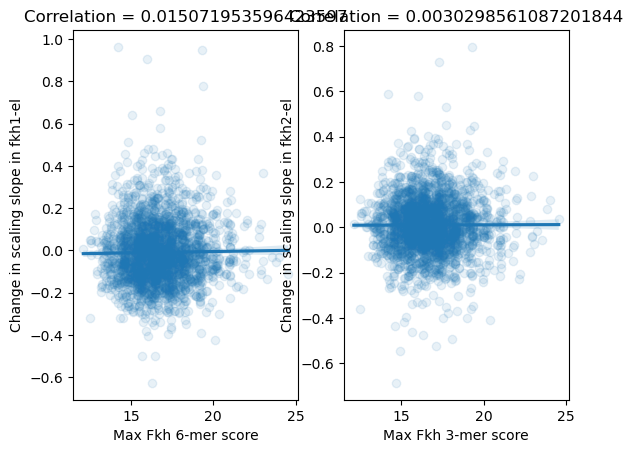

In [28]:
plt.subplot(1,2,1)
sb.regplot(df_trunc_6mer.join(delta_slopes), x='Max',y='fkh1_deviation_from_wt',scatter_kws={'alpha':0.1})
plt.xlabel('Max Fkh 6-mer score')
plt.ylabel('Change in scaling slope in fkh1-el')
R,P = np.corrcoef(*nonan_pairs(df_trunc_6mer.join(delta_slopes)['Max'],
                  df_trunc_6mer.join(delta_slopes)['fkh1_deviation_from_wt']))
plt.title(f'Correlation = {R[1]}')

plt.subplot(1,2,2)
sb.regplot(df_trunc_6mer.join(delta_slopes), x='Max',y='fkh2_deviation_from_wt',scatter_kws={'alpha':0.1})
plt.xlabel('Max Fkh 3-mer score')
plt.ylabel('Change in scaling slope in fkh2-el')
R,P = np.corrcoef(*nonan_pairs(df_trunc_6mer.join(delta_slopes)['Max'],
                  df_trunc_6mer.join(delta_slopes)['fkh2_deviation_from_wt']))
plt.title(f'Correlation = {R[1]}')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/slope_change_v_6mer_scores.eps',format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


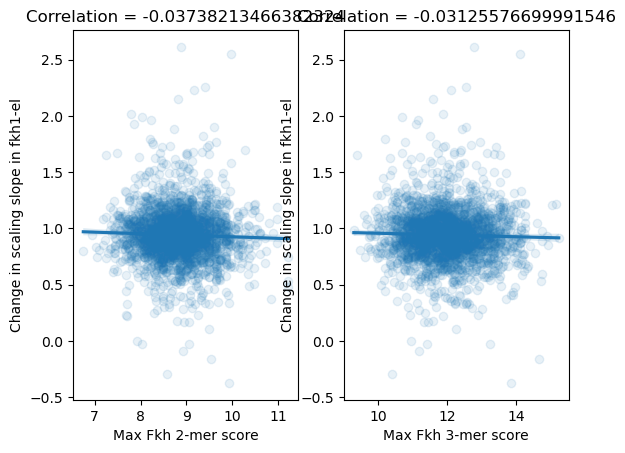

In [29]:
plt.subplot(1,2,1)
sb.regplot(df_full_2mer.join(delta_slopes), x='Max',y='WT',scatter_kws={'alpha':0.1})
plt.xlabel('Max Fkh 2-mer score')
plt.ylabel('Change in scaling slope in fkh1-el')
R,P = np.corrcoef(*nonan_pairs(df_full_2mer.join(delta_slopes)['Max'],
                  df_full_2mer.join(delta_slopes)['WT']))
plt.title(f'Correlation = {R[1]}')

plt.subplot(1,2,2)
sb.regplot(df_full_3mer.join(delta_slopes), x='Max',y='WT',scatter_kws={'alpha':0.1})
plt.xlabel('Max Fkh 3-mer score')
plt.ylabel('Change in scaling slope in fkh1-el')
R,P = np.corrcoef(*nonan_pairs(df_full_3mer.join(delta_slopes)['Max'],
                  df_full_3mer.join(delta_slopes)['WT']))
plt.title(f'Correlation = {R[1]}')

plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/WT_slope_v_23mer_scores.eps',format='eps')

,Name,WT,fkh1,fkh2,fkh1_del,fkh2_del,fkh1_deviation_from_wt,pca1_along_wt,fkh2_deviation_from_wt,pca2_along_wt
gene_name,,,,,,,,,,
YOR014W,RTS1,0.908595,1.016870,0.993789,0.108275,0.085193,0.076562,1.361509,0.060241,1.345189
YAL016W,TPD3,0.842219,0.660735,0.821302,-0.181483,-0.020917,-0.128328,1.062749,-0.014791,1.176287
YGL190C,CDC55,0.846391,0.969036,1.058722,0.122645,0.212331,0.086723,1.283701,0.150140,1.347118
YJR149W,NaN,0.945999,0.924471,0.824763,-0.021527,-0.121236,-0.015222,1.322622,-0.085727,1.252117
YJR025C,BNA1,1.044403,0.889102,0.718665,-0.155301,-0.325738,-0.109814,1.367194,-0.230331,1.246677
...,...,...,...,...,...,...,...,...,...,...
YOL109W,ZEO1,0.276990,0.685096,0.486641,0.408106,0.209651,0.288574,0.680297,0.148246,0.539968
YGR211W,ZPR1,1.126604,0.919364,1.084252,-0.207240,-0.042352,-0.146541,1.446718,-0.029947,1.563312
YMR243C,ZRC1,0.915040,0.624913,0.889195,-0.290127,-0.025845,-0.205151,1.088911,-0.018275,1.275787


In [30]:
#%% Generate 'background' via permutation and calculate scores

nt_counts = {}

for chrom in yeast_genome.keys():
    if chrom == 'NC_027264.1': # MT DNA
        continue
    nts = pd.DataFrame(list(yeast_genome[chrom][:].seq.upper()),columns=['Nucleotide'])
    nts['Count'] = 1
    nt_counts[chrom] = nts.groupby('Nucleotide')['Count'].sum()

nt_counts = pd.DataFrame(nt_counts).T
nt_counts.loc['Genome'] = nt_counts.sum(axis=0)

nt_freq = nt_counts.loc['Genome'] / nt_counts.loc['Genome'].sum()

# Assume i.i.d. nucleotides and generate a random 1000mer sequence

from random import choices

rand_scores = np.array(
    [ get_pswm_score_fast(Fkh,choices(nt_freq.index.values, weights=nt_freq.values,k=len(Fkh)+1))[0]
    for i in tqdm(range(100000))])

#%%

100%|████████████████████████████████| 100000/100000 [00:01<00:00, 56919.54it/s]


NameError: name 'df' is not defined

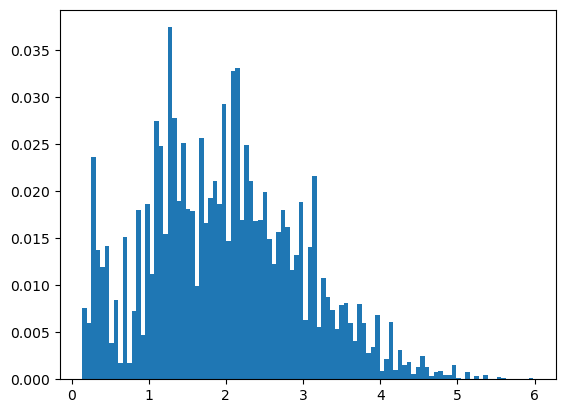

In [31]:

plt.hist(rand_scores,100, weights=np.ones(len(rand_scores))/len(rand_scores))

plt.vlines(x = df.loc['YOR083W','Max'],ymin=0,ymax=0.02,color='r')
plt.xlabel('Fkh1 motif 2mer match scores')
plt.ylabel('Frequency')
plt.legend(['Max score within Whi5 promoter','Random sequences (S.c. nt frequency)'])

p_val = (rand_scores>df.loc['YOR083W','Max']).sum() / 1e6
plt.title(f'P-value = {p_val}')


## AAACA truncated substring searches <a class="anchor" id="string"></a>

In [22]:
'''

Count instances of 'AAACA' n-mer occurs per promoter

'''
from re import findall

count_1mer = {gene:len(findall('AAACA',sequence[500:1000].seq)) for gene,sequence in promoters.items() if not gene.startswith('Q')}
count_2mer = {gene:len(findall('AAACAAAACA',sequence[500:1000].seq)) for gene,sequence in promoters.items() if not gene.startswith('Q')}
count_3mer = {gene:len(findall('AAACAAAACAAAACA',
                               sequence[500:1000].seq)) for gene,sequence in promoters.items() if not gene.startswith('Q')}
count_4mer = {gene:len(findall('AAACAAAACAAAACAAAACA',
                               sequence[500:1000].seq)) for gene,sequence in promoters.items() if not gene.startswith('Q')}
count_5mer = {gene:len(findall('AAACAAAACAAAACAAAACAAAACA',
                               sequence[500:1000].seq)) for gene,sequence in promoters.items() if not gene.startswith('Q')}
count_6mer = {gene:len(findall('ACAAAACAAAACAAAACAAAACAAAACAAA',
                               sequence[500:1000].seq)) for gene,sequence in promoters.items() if not gene.startswith('Q')}

counts = pd.Series(count_1mer)
counts = pd.DataFrame(counts,columns=['1mer'])
counts['2mer'] = count_2mer
counts['3mer'] = count_3mer
counts['4mer'] = count_4mer
counts['5mer'] = count_5mer
counts['6mer'] = count_6mer
I = (counts.sum(axis=1) > 0)
counts['max nmer'] = 0
counts.loc[I,'max nmer'] = [np.where(row == 0)[0][0] for idx,row in counts.iterrows() if row.sum() > 0]

In [23]:
promoters['YOR083W'][500:1000].seq

'TTTCTGGGAAGACAAATCGGATATGAGCAGCTGTTTACGGGAGAGAGTCTTGTGGTATAACCATTTGAAGAGCGATGATGAGTCTGTGGCAGGAGTGTTGGAAAGTTCGTAGTATTTGGATAAAAGAAATTCTGTTACTGGCAAGGTATTAGACATAGCAACGAAACAGAACCGTCTTCCTTGTGCTGTTTATGATGTCTTTTGTCTCCTATTGTTTTCGAATTTTATTTTTTTTTTTTTTTATTTTTTTATTTTTTTTTGTTTTATATAATTCCTCGCGCTGCCTTAATGATAATTCTTGATTTACTAATTGTTTCATGACTTCTGGTGCTAAAGGGAAGGGGGAAAAGGGAAGCGAAAACTTCAAGAGCAGAACGAAAAAAATAAAAAAAACAAAACAAAACAAAACAAAACAAAGGCAAAACAAGGCAAAGAACCTGATGGAAGAAAGCACAACCAGATATTAATAGCAACGAAAAATAGTAGAGACATTGAAGAAT'

In [24]:
print('--- ACAAA count ---')
whi5_1mer_rank = np.where(counts.sort_values('1mer').index == 'YOR083W')[0][0]
whi5_2mer_rank = np.where(counts.sort_values('2mer').index == 'YOR083W')[0][0]
whi5_3mer_rank = np.where(counts.sort_values('3mer').index == 'YOR083W')[0][0]
whi5_4mer_rank = np.where(counts.sort_values('4mer').index == 'YOR083W')[0][0]
whi5_5mer_rank = np.where(counts.sort_values('5mer').index == 'YOR083W')[0][0]
whi5_6mer_rank = np.where(counts.sort_values('6mer').index == 'YOR083W')[0][0]

print(f'Whi5 promoter 1mer rank: {len(counts)-whi5_1mer_rank} out of {len(counts)}')
print(f'Whi5 promoter 2mer rank: {len(counts)-whi5_2mer_rank} out of {len(counts)}')
print(f'Whi5 promoter 3mer rank: {len(counts)-whi5_3mer_rank} out of {len(counts)}')
print(f'Whi5 promoter 4mer rank: {len(counts)-whi5_4mer_rank} out of {len(counts)}')
print(f'Whi5 promoter 5mer rank: {len(counts)-whi5_5mer_rank} out of {len(counts)}')
print(f'Whi5 promoter 6mer rank: {len(counts)-whi5_6mer_rank} out of {len(counts)}')


--- ACAAA count ---
Whi5 promoter 1mer rank: 7 out of 6694
Whi5 promoter 2mer rank: 3 out of 6694
Whi5 promoter 3mer rank: 2 out of 6694
Whi5 promoter 4mer rank: 1 out of 6694
Whi5 promoter 5mer rank: 1 out of 6694
Whi5 promoter 6mer rank: 3618 out of 6694


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


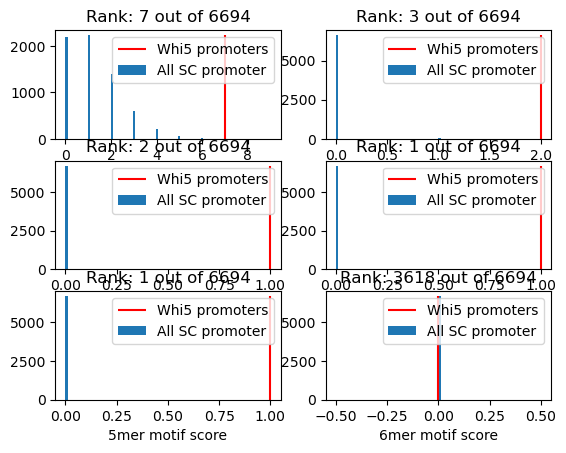

In [14]:

def plot_counts_and_highlight_whi5(counts,field='1mer',motif_name='Fkh'):
    x,_,_ = plt.hist(counts[field],100)
    plt.vlines(counts.loc['YOR083W',field],ymin=0,ymax=x.max(),color='r')
    plt.xlabel(f'{motif_name} motif score')
    plt.legend(['Whi5 promoters','All SC promoter'])

plt.subplot(3,2,1)
plot_counts_and_highlight_whi5(counts,field='1mer',motif_name='1mer')
plt.title(f'Rank: {len(counts)-whi5_1mer_rank} out of {len(counts)}')
plt.subplot(3,2,2)
plot_counts_and_highlight_whi5(counts,field='2mer',motif_name='2mer')
plt.title(f'Rank: {len(counts)-whi5_2mer_rank} out of {len(counts)}')
plt.subplot(3,2,3)
plot_counts_and_highlight_whi5(counts,field='3mer',motif_name='3mer')
plt.title(f'Rank: {len(counts)-whi5_3mer_rank} out of {len(counts)}')
plt.subplot(3,2,4)
plot_counts_and_highlight_whi5(counts,field='4mer',motif_name='4mer')
plt.title(f'Rank: {len(counts)-whi5_4mer_rank} out of {len(counts)}')
plt.subplot(3,2,5)
plot_counts_and_highlight_whi5(counts,field='5mer',motif_name='5mer')
plt.title(f'Rank: {len(counts)-whi5_5mer_rank} out of {len(counts)}')
plt.subplot(3,2,6)
plot_counts_and_highlight_whi5(counts,field='6mer',motif_name='6mer')
plt.title(f'Rank: {len(counts)-whi5_6mer_rank} out of {len(counts)}')
plt.savefig(path.join(dirname,'AACAAA_counts.eps'),format='eps')


In [20]:
counts.sort_values('1mer',ascending=False)

,1mer,2mer,3mer,4mer,5mer,6mer
YNR009W,9,0,0,0,0,0
YGL219C,8,1,0,0,0,0
YML085C,8,2,1,1,0,0
YHR138C,8,0,0,0,0,0
YER155C,7,0,0,0,0,0
...,...,...,...,...,...,...
YML081W,0,0,0,0,0,0
YFR049W,0,0,0,0,0,0
YML076C,0,0,0,0,0,0
YFR046C,0,0,0,0,0,0


## Correlate to subscaling or changes <a class="anchor" id="scaling"></a>

Text(0, 0.5, '3-mer count')

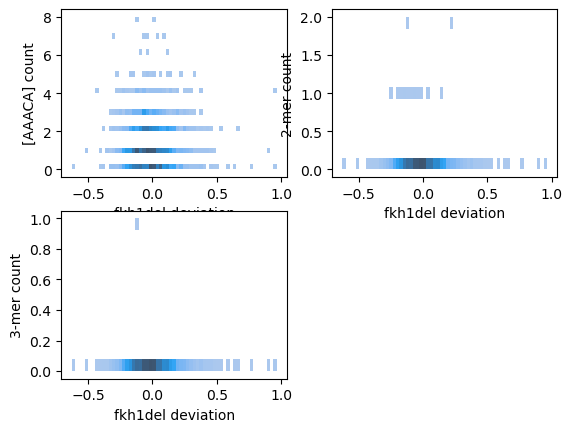

In [83]:
'''
Take the top scaling change genes -> Look for n-mers -> look at their Fkh1 n-mer rate
'''

slopes_fkh1_sorted = delta_slopes.sort_values('fkh1_deviation_from_wt',ascending=False) # sorted by genes that GAIN slope with fkh1 deletion
slopes_fkh1_sorted = slopes_fkh1_sorted.join(counts)

# Bin by scaling differences and 
# bins = np.linspace(delta_slopes['fkh1_deviation_from_wt'].min(),delta_slopes['fkh1_deviation_from_wt'].max(),20)
# which_bin = np.digitize(slopes_fkh1_sorted['fkh1_deviation_from_wt'],bins)
# slopes_fkh1_sorted['fkh1_deviation_bin'] = which_bin
# # np.histogram(delta_slopes['fkh1_deviation_from_wt'])

plt.subplot(2,2,1)
sb.histplot(slopes_fkh1_sorted,x='fkh1_deviation_from_wt',y='1mer')
plt.xlabel('fkh1del deviation'); plt.ylabel('[AAACA] count')
plt.subplot(2,2,2)
sb.histplot(slopes_fkh1_sorted,x='fkh1_deviation_from_wt',y='2mer')
plt.xlabel('fkh1del deviation'); plt.ylabel('2-mer count')
plt.subplot(2,2,3)
sb.histplot(slopes_fkh1_sorted,x='fkh1_deviation_from_wt',y='3mer')
plt.xlabel('fkh1del deviation'); plt.ylabel('3-mer count')


In [78]:
'''
Load CHEP-seq datasets
'''
import pyBigWig

fkh_filelist = glob(path.join(dirname,'Fkh_ChEC-seq/*FKH1*.bw'))
bw = pyBigWig.open(fkh_filelist[0])

# ... stop for now